In [1]:
import pandas as pd
import numpy as np
import torch
from torchcast.kalman_filter import KalmanFilter

from torchcast.process import LocalTrend, Season
from torchcast.utils.data import TimeSeriesDataset

In [2]:
def extract_time_series_cats(df, cat):
    new_df = df[df['Item Name'].str.contains(cat, case=False)]
    day_df = new_df.groupby('date').agg(quantity = ('Quantity', 'sum'))
    day_df = day_df.reset_index()
    day_df.rename(columns = {'quantity': f'{item.replace(" ", "")}Quantity'}, inplace=True)
    day_df['date'] = pd.to_datetime(day_df['date'])
    return day_df

In [3]:
cats = ['Chicken', 'Lamb', 'Prawn', 'Naan']

In [4]:
df = pd.read_pickle('data/restaurant/processed1.pkl')
multi_df1 = pd.DataFrame()
multi_df1['date'] = pd.date_range(start = "2016-07-18", end = "2019-08-03")
for item in cats:
    tmp_df = extract_time_series_cats(df, item)
    multi_df1 = pd.merge(multi_df1, tmp_df, on='date', how='outer')
multi_df1 = multi_df1.fillna(0)
multi_df1 = multi_df1.sort_values('date')
multi_df1 = multi_df1.reset_index()

In [5]:
df2 = pd.read_pickle('data/restaurant/processed2.pkl')
multi_df2 = pd.DataFrame()
multi_df2['date'] = pd.date_range(start = "2016-07-18", end = "2019-08-03")
for item in cats:
    tmp_df = extract_time_series_cats(df2, item)
    multi_df2 = pd.merge(multi_df2, tmp_df, on='date', how='outer')
multi_df2 = multi_df2.fillna(0)
multi_df2 = multi_df2.sort_values('date')
multi_df2 = multi_df2.reset_index()

In [6]:
if 'index' in multi_df1.columns.tolist(): 
    multi_df1 = multi_df1.drop(columns=['index'])
if 'index' in multi_df2.columns.tolist(): 
    multi_df2 = multi_df2.drop(columns=['index'])

In [7]:
multi_df1['restaurant'] = [1]*len(multi_df1)
multi_df2['restaurant'] = [2]*len(multi_df2)

In [8]:
# Create datasets (Might need to normalize)
time_ds1 = TimeSeriesDataset.from_dataframe(
    dataframe=multi_df1,
    dt_unit='D',
    measure_colnames=multi_df1.columns.tolist()[1:-1],
    group_colname='restaurant',
    time_colname='date'
)

time_ds2 = TimeSeriesDataset.from_dataframe(
    dataframe=multi_df2,
    dt_unit='D',
    measure_colnames=multi_df2.columns.tolist()[1:-1],
    group_colname='restaurant',
    time_colname='date'
)

split_time = pd.to_datetime('2018-12-24')
ds1_train, ds1_val = time_ds1.train_val_split(dt=split_time)
ds2_train, ds2_val = time_ds2.train_val_split(dt=split_time)

In [9]:
# Setup model
processes = []
for m in ds1_train.measures[0]:
    processes.extend([
        LocalTrend(id=f'{m}_trend', measure=m),
        Season(id=f'{m}_day_of_week', period=7, dt_unit='D', K=3, measure=m, fixed=True),
        Season(id=f'{m}_day_of_year', period=365.25, dt_unit='D', K=6, measure=m, fixed=True)
    ])
kf = KalmanFilter(measures=ds1_train.measures[0], processes=processes)

In [10]:
kf.fit(
    ds1_train.tensors[0],
    max_iter=50,
    n_step=7,
    every_step=False,
    start_offsets=ds1_train.start_datetimes
)

  0%|          | 0/12 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='ChickenQuantity_trend'), Season(id='ChickenQuantity_day_of_week'), Season(id='ChickenQuantity_day_of_year'), LocalTrend(id='LambQuantity_trend'), Season(id='LambQuantity_day_of_week'), Season(id='LambQuantity_day_of_year'), LocalTrend(id='PrawnQuantity_trend'), Season(id='PrawnQuantity_day_of_week'), Season(id='PrawnQuantity_day_of_year'), LocalTrend(id='NaanQuantity_trend'), Season(id='NaanQuantity_day_of_week'), Season(id='NaanQuantity_day_of_year')], measures=['ChickenQuantity', 'LambQuantity', 'PrawnQuantity', 'NaanQuantity'])

In [11]:
pred = kf(
        ds1_train.tensors[0],
        start_offsets=ds1_train.start_datetimes,
        out_timesteps=time_ds1.tensors[0].shape[1]
)

loss = -pred.log_prob(ds1_train.tensors[0]).mean()
print(loss)

tensor(10.2697, grad_fn=<NegBackward0>)


In [12]:
df_pred = pred.to_dataframe(time_ds1, multi=None)
df_pred

,actual,group,mean,measure,std,time
0,0.0,1,2.650072,ChickenQuantity,13.313367,2016-07-18
1,3.0,1,1.771188,ChickenQuantity,6.724725,2016-07-19
2,3.0,1,0.752665,ChickenQuantity,6.497625,2016-07-20
3,12.0,1,-1.175398,ChickenQuantity,7.900673,2016-07-21
4,12.0,1,7.217631,ChickenQuantity,9.895999,2016-07-22
...,...,...,...,...,...,...
1107,9.0,1,7.340174,NaanQuantity,5.498240,2019-07-30
1108,13.0,1,7.818278,NaanQuantity,5.496998,2019-07-31
1109,7.0,1,8.575977,NaanQuantity,5.501180,2019-08-01
1110,15.0,1,16.114004,NaanQuantity,5.497079,2019-08-02


/home/21651388/anaconda3/envs/HackathonTakeAway/lib/python3.10/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


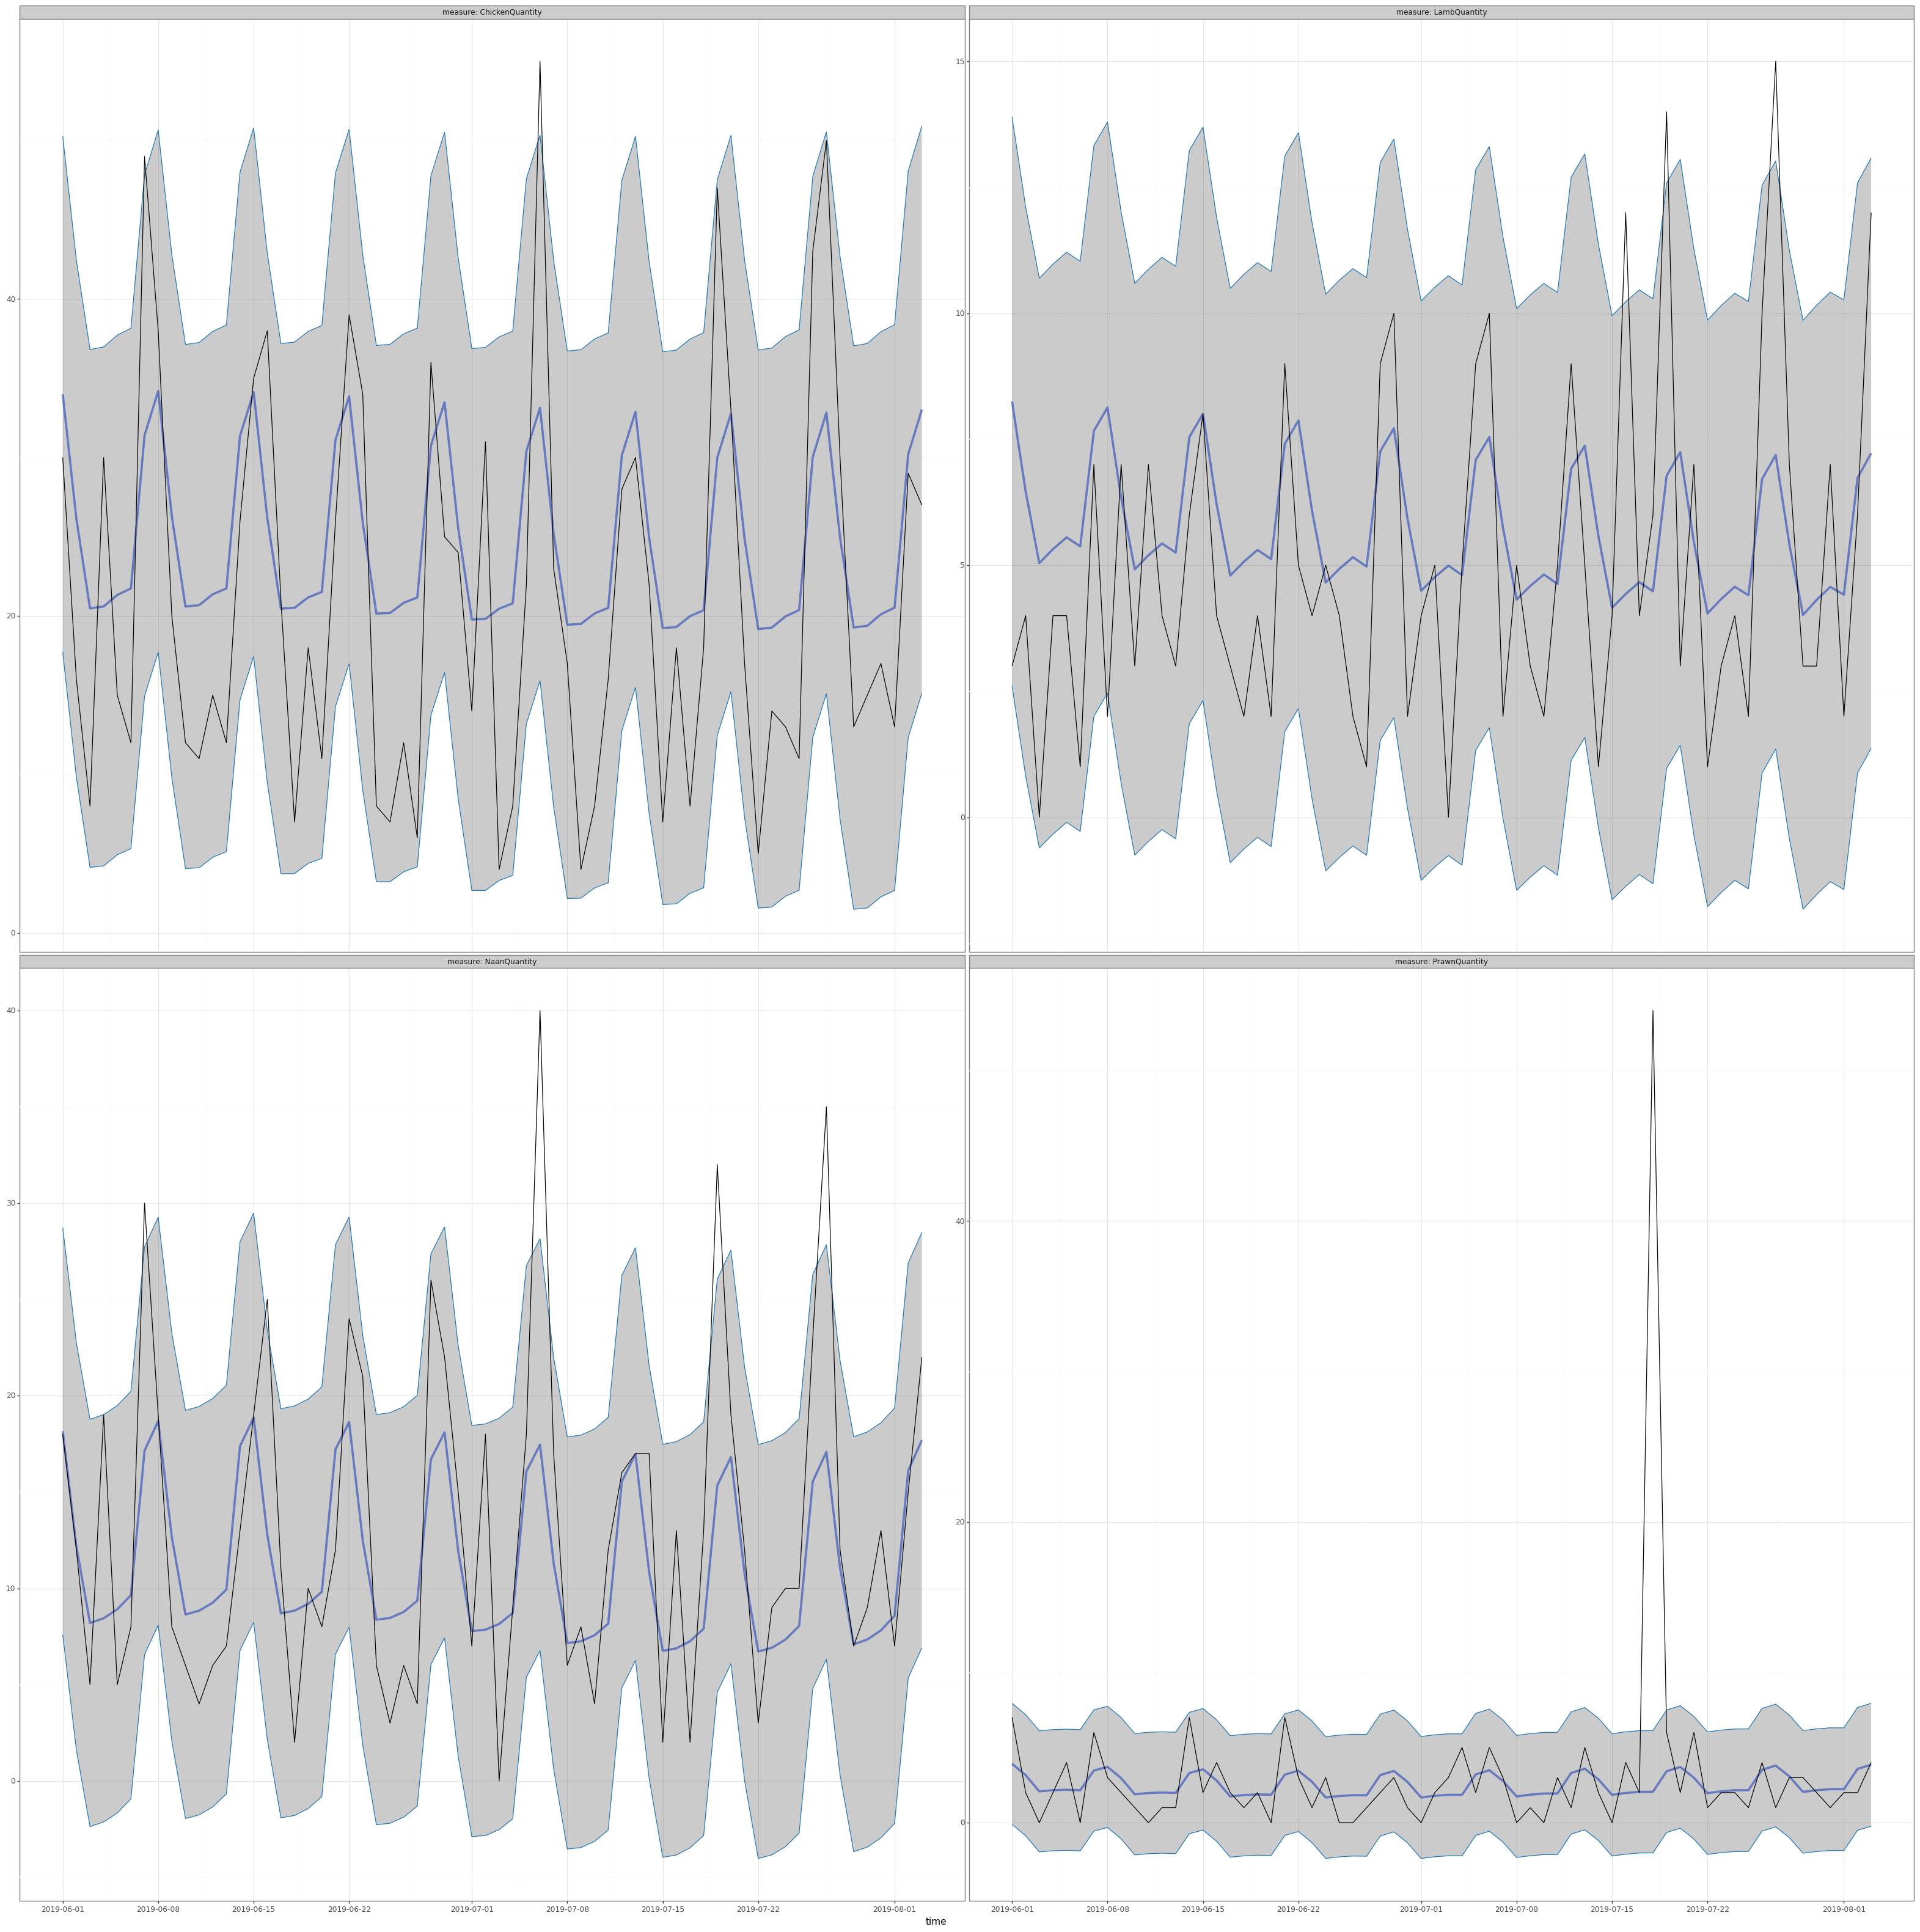

In [13]:
print(pred.plot(df_pred.query("group==1 & time.dt.year==2019 & time.dt.month>=6"), figure_size=(40, 40)))

In [14]:
val_df_pred = df_pred.query("time>@split_time")
val_df_pred = val_df_pred.reset_index()
if 'index' in val_df_pred.columns.tolist(): 
    val_df_pred = val_df_pred.drop(columns=['index'])

In [15]:
total_df = val_df_pred.groupby('time').agg(predict = ('mean', 'sum'), true = ('actual', 'sum'))
total_df = total_df.reset_index()
if 'index' in total_df.columns.tolist(): 
    total_df = total_df.drop(columns=['index'])
chicken_df = val_df_pred[val_df_pred['measure'] == 'ChickenQuantity']
lamb_df = val_df_pred[val_df_pred['measure'] == 'LambQuantity']
prawn_df = val_df_pred[val_df_pred['measure'] == 'PrawnQuantity']
naan_df = val_df_pred[val_df_pred['measure'] == 'NaanQuantity']

In [16]:
total_rmse = ((val_df_pred['mean'] - val_df_pred['actual']) ** 2).mean() ** .5
total_rmse2 = ((total_df['predict'] - total_df['true']) ** 2).mean() ** .5
chicken_rmse = ((chicken_df['mean'] - chicken_df['actual']) ** 2).mean() ** .5
lamb_rmse = ((lamb_df['mean'] - lamb_df['actual']) ** 2).mean() ** .5
prawn_rmse = ((prawn_df['mean'] - prawn_df['actual']) ** 2).mean() ** .5
naan_rmse = ((naan_df['mean'] - naan_df['actual']) ** 2).mean() ** .5

rmse_df = pd.DataFrame({'Category': ['Total', 'Total2', 'Chicken', 'Lamb', 'Prawn', 'Naan'],
                   'RMSE': [total_rmse, total_rmse2, chicken_rmse, lamb_rmse, prawn_rmse, naan_rmse]})

In [17]:
rmse_df

,Category,RMSE
0,Total,6.808375
1,Total2,19.218469
2,Chicken,10.557941
3,Lamb,3.217281
4,Prawn,3.974945
5,Naan,6.913376


In [9]:
# Setup model
processes = []
for m in ds2_train.measures[0]:
    processes.extend([
        LocalTrend(id=f'{m}_trend', measure=m),
        Season(id=f'{m}_day_of_week', period=7, dt_unit='D', K=3, measure=m, fixed=True),
        Season(id=f'{m}_day_of_year', period=365.25, dt_unit='D', K=6, measure=m, fixed=True)
    ])
kf = KalmanFilter(measures=ds2_train.measures[0], processes=processes)

In [10]:
kf.fit(
    ds2_train.tensors[0],
    max_iter=50,
    n_step=7,
    every_step=False,
    start_offsets=ds2_train.start_datetimes
)

  0%|          | 0/12 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='ChickenQuantity_trend'), Season(id='ChickenQuantity_day_of_week'), Season(id='ChickenQuantity_day_of_year'), LocalTrend(id='LambQuantity_trend'), Season(id='LambQuantity_day_of_week'), Season(id='LambQuantity_day_of_year'), LocalTrend(id='PrawnQuantity_trend'), Season(id='PrawnQuantity_day_of_week'), Season(id='PrawnQuantity_day_of_year'), LocalTrend(id='NaanQuantity_trend'), Season(id='NaanQuantity_day_of_week'), Season(id='NaanQuantity_day_of_year')], measures=['ChickenQuantity', 'LambQuantity', 'PrawnQuantity', 'NaanQuantity'])

In [11]:
pred = kf(
        ds2_train.tensors[0],
        start_offsets=ds2_train.start_datetimes,
        out_timesteps=time_ds2.tensors[0].shape[1]
)

loss = -pred.log_prob(ds2_train.tensors[0]).mean()
print(loss)

tensor(10.8700, grad_fn=<NegBackward0>)


In [12]:
df_pred = pred.to_dataframe(time_ds2, multi=None)
df_pred

,actual,group,mean,measure,std,time
0,0.0,2,0.200770,ChickenQuantity,17.977594,2016-07-18
1,0.0,2,-0.135596,ChickenQuantity,12.716065,2016-07-19
2,0.0,2,1.403900,ChickenQuantity,15.852120,2016-07-20
3,0.0,2,1.063799,ChickenQuantity,10.519104,2016-07-21
4,0.0,2,0.987411,ChickenQuantity,20.050745,2016-07-22
...,...,...,...,...,...,...
1107,24.0,2,9.258369,NaanQuantity,6.817640,2019-07-30
1108,3.0,2,10.827816,NaanQuantity,6.817863,2019-07-31
1109,14.0,2,11.827525,NaanQuantity,6.817292,2019-08-01
1110,26.0,2,25.886204,NaanQuantity,6.820148,2019-08-02


In [14]:
val_df_pred = df_pred.query("time>@split_time")
val_df_pred = val_df_pred.reset_index()
if 'index' in val_df_pred.columns.tolist(): 
    val_df_pred = val_df_pred.drop(columns=['index'])

In [15]:
total_df = val_df_pred.groupby('time').agg(predict = ('mean', 'sum'), true = ('actual', 'sum'))
total_df = total_df.reset_index()
if 'index' in total_df.columns.tolist(): 
    total_df = total_df.drop(columns=['index'])
chicken_df = val_df_pred[val_df_pred['measure'] == 'ChickenQuantity']
lamb_df = val_df_pred[val_df_pred['measure'] == 'LambQuantity']
prawn_df = val_df_pred[val_df_pred['measure'] == 'PrawnQuantity']
naan_df = val_df_pred[val_df_pred['measure'] == 'NaanQuantity']

In [16]:
total_rmse = ((val_df_pred['mean'] - val_df_pred['actual']) ** 2).mean() ** .5
total_rmse2 = ((total_df['predict'] - total_df['true']) ** 2).mean() ** .5
chicken_rmse = ((chicken_df['mean'] - chicken_df['actual']) ** 2).mean() ** .5
lamb_rmse = ((lamb_df['mean'] - lamb_df['actual']) ** 2).mean() ** .5
prawn_rmse = ((prawn_df['mean'] - prawn_df['actual']) ** 2).mean() ** .5
naan_rmse = ((naan_df['mean'] - naan_df['actual']) ** 2).mean() ** .5

rmse_df = pd.DataFrame({'Category': ['Total', 'Total2', 'Chicken', 'Lamb', 'Prawn', 'Naan'],
                   'RMSE': [total_rmse, total_rmse2, chicken_rmse, lamb_rmse, prawn_rmse, naan_rmse]})

In [17]:
rmse_df

,Category,RMSE
0,Total,8.158204
1,Total2,24.271298
2,Chicken,13.297783
3,Lamb,4.286868
4,Prawn,2.412619
5,Naan,8.074408
